In [2]:
%pip install pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.6 MB 9.3 MB/s eta 0:00:05
    --------------------------------------- 0.7/38.6 MB 8.2 MB/s eta 0:00:05
   - -------------------------------------- 1.0/38.6 MB 7.9 MB/s eta 0:00:05
   - -------------------------------------- 1.3/38.6 MB 8.2 MB/s eta 0:00:05
   -- ------------------------------------- 2.0/38.6 MB 9.3 MB/s eta 0:00:04
   -- ------------------------------------- 2.6/38.6 MB 9.7 MB/s eta 0:00:04
   --- ------------------------------------ 3.0/38.6 MB 9.5 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/38.6 MB 9.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.8/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.2/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.8/38.6 MB 9.5 MB/s eta 0:00:04
   ----- ---------------------------------- 5.3/38.6 MB 9.3 MB/s eta 0:00:04
   --

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Mrudula\AppData\Local\Temp\ipykernel_2124\183779410.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [16]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
#from skimage import io
from tqdm import tqdm

In [17]:
mydir = 'CoffeeBeanQualityData/train/'

In [18]:
categories = ['Green','Light','Medium','Dark']
data =[]
for i in categories:
  folder_path = os.path.join(mydir,i)
  if(i=='Green'):
    label = 0
  elif(i=='Light'):
    label = 1
  elif(i=='Medium'):
    label = 2
  else:
    label = 3
  for j in os.listdir(folder_path):
    img_path = os.path.join(folder_path, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224, 224))
    data.append([img,label])

In [19]:
import random
random.shuffle(data)

In [20]:
x=[]
y=[]

for i in data:
  x.append(i[0])
  y.append(i[1])

In [21]:
y = np.array(y)
x = np.array(x)

Load Images in Data Generator

In [22]:
image_size = (224, 224)
batch_size = 64
datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=45,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.25,
            zoom_range=0.25,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
            validation_split = 0.1)

In [150]:
train_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [24]:
train_ds.class_indices

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

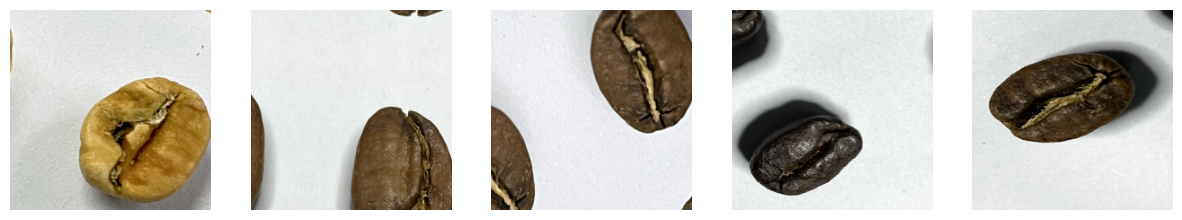

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [26]:
from keras import applications

In [27]:
vgg_base = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
vgg_base.trainable = False

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout

In [29]:
inputs = Input(shape=(224, 224, 3))

x = vgg_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation = 'sigmoid')(x)
vgg_model = Model(inputs, outputs)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                             

In [30]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [31]:
epochs = 25
hist = vgg_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
vgg_model.save('vgg.hdf5') #this saves the model with the weights

Epoch 1/25


C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



17/17 [==============================] - 354s 18s/step - loss: 1.4586 - categorical_accuracy: 0.2843 - val_loss: 1.3324 - val_categorical_accuracy: 0.2667
Epoch 2/25
17/17 [==============================] - 259s 15s/step - loss: 1.1701 - categorical_accuracy: 0.4833 - val_loss: 1.1891 - val_categorical_accuracy: 0.4917
Epoch 3/25
17/17 [==============================] - 248s 15s/step - loss: 1.0029 - categorical_accuracy: 0.5981 - val_loss: 1.0530 - val_categorical_accuracy: 0.6000
Epoch 4/25
17/17 [==============================] - 243s 14s/step - loss: 0.8834 - categorical_accuracy: 0.6630 - val_loss: 1.0086 - val_categorical_accuracy: 0.6250
Epoch 5/25
17/17 [==============================] - 213s 12s/step - loss: 0.7674 - categorical_accuracy: 0.7306 - val_loss: 0.8992 - val_categorical_accuracy: 0.6667
Epoch 6/25
17/17 [==============================] - 229s 14s/step - loss: 0.7268 - categorical_accuracy: 0.7231 - val_loss: 0.8955 - val_categorical_accuracy: 0.6250
Epoch 7/25
17/

C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


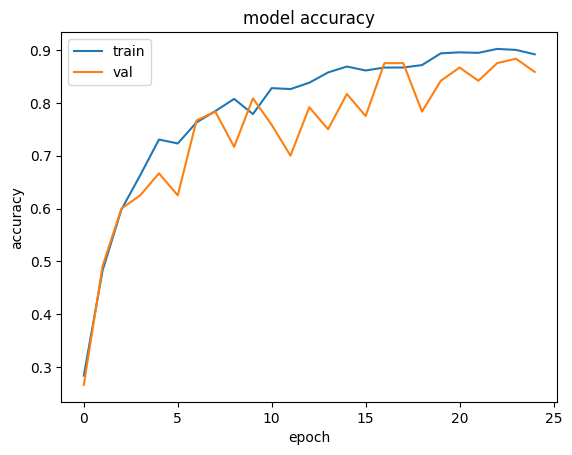

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

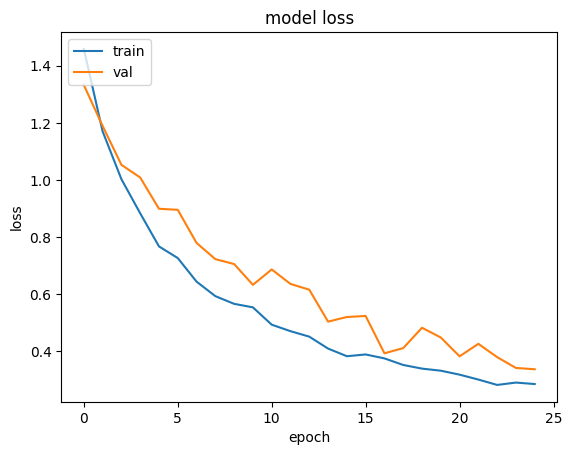

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [139]:
my_testdir = 'CoffeeBeanQualityData/test/'

In [142]:
test_ds = datagen.flow_from_directory(my_testdir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",
                                      shuffle=False )

Found 360 images belonging to 4 classes.


In [143]:
from tensorflow import keras

loaded_model = keras.models.load_model('vgg.hdf5')

pred_probabilities = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probabilities, axis=1)

# Print the predicted labels
print(pred_labels)

6/6 [==============================] - 116s 14s/step
[0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 1
 2 1 2 2 2 2 2 1 2 2 1 3 3 0 3 3 3 0 0 3 3 0 3 3 0 3 3 3 0 3 3 1 3 3 3 3 0
 3 0 3 3 3 3 3 3 3 0 3 3 3 3 3 0 3 3 3 0 3 3 0 3 3 3 3 3 0 3 3 3 3 3 3 2 3
 3 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 2 3]


In [146]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
true_labels = test_ds.classes

# Get class indices mapping from the test data generator
class_indices = test_ds.class_indices

# Generate classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_indices, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Print classification report with accuracy
print("Classification Report:")
print(class_report)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

Classification Report:
{'Dark': {'precision': 0.86, 'recall': 0.9555555555555556, 'f1-score': 0.9052631578947369, 'support': 90.0}, 'Green': {'precision': 0.8910891089108911, 'recall': 1.0, 'f1-score': 0.9424083769633509, 'support': 90.0}, 'Light': {'precision': 0.9529411764705882, 'recall': 0.9, 'f1-score': 0.9257142857142857, 'support': 90.0}, 'Medium': {'precision': 0.9594594594594594, 'recall': 0.7888888888888889, 'f1-score': 0.8658536585365852, 'support': 90.0}, 'accuracy': 0.9111111111111111, 'macro avg': {'precision': 0.9158724362102346, 'recall': 0.9111111111111111, 'f1-score': 0.9098098697772397, 'support': 360.0}, 'weighted avg': {'precision': 0.9158724362102347, 'recall': 0.9111111111111111, 'f1-score': 0.9098098697772397, 'support': 360.0}}
Accuracy: 0.9111111111111111

Confusion Matrix:
[[86  1  0  3]
 [ 0 90  0  0]
 [ 0  9 81  0]
 [14  1  4 71]]


In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_indices, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_indices))



Classification Report:
              precision    recall  f1-score   support

        Dark       0.86      0.96      0.91        90
       Green       0.89      1.00      0.94        90
       Light       0.95      0.90      0.93        90
      Medium       0.96      0.79      0.87        90

    accuracy                           0.91       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.91      0.91       360



Classification Report:
Accuracy: 0.9111111111111111


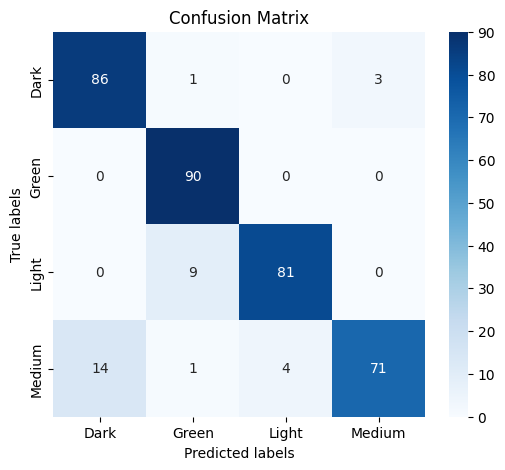

In [159]:
print("Classification Report:")
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [129]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    #return clas
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 [==============================] - 0s 215ms/step
The given image is of 
Class: 2 
Species: Light


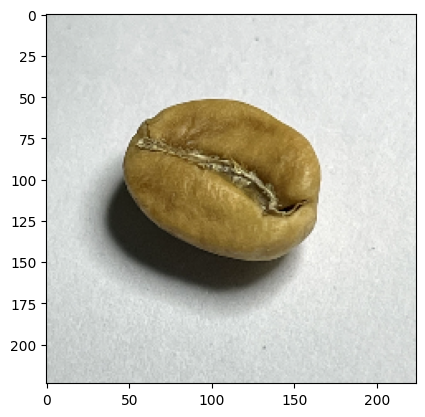

In [130]:
predictor('CoffeeBeanQualityData/test/Light/light (15).png', vgg_model)

1/1 [==============================] - 0s 162ms/step
The given image is of 
Class: 3 
Species: Medium


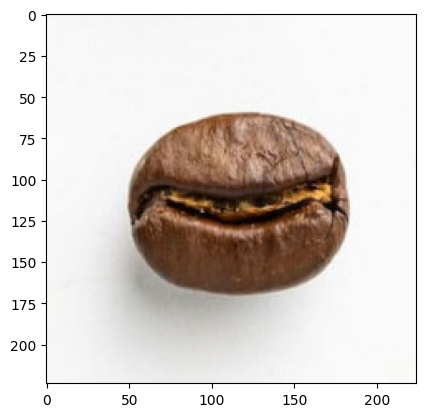

In [90]:
predictor('medium-roast-coffee-bean.jpg', vgg_model)

Frontend

In [5]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%%writefile app.py
import streamlit as st
import tensorflow as tf


st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache_data
def load_model():
  model = tf.keras.models.load_model('vgg.hdf5')
  return model

st.markdown(
    """
    <style>
    .st-emotion-cache-fg4pbf {
        background-image: url("backgr.jpg");
        background-size: cover;
    }
    </style>
    """,
    unsafe_allow_html=True
)
st.title(""" Coffee Bean Quality Prediction App""")

file = st.file_uploader("Please upload an image file", type=["jpg", "png"])

import cv2
import numpy as np
from PIL import Image, ImageOps
    

def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = np.array(image, dtype = 'float32')/255.0
    #img = np.asarray(image)
    img_reshape = img[np.newaxis, ...]
    prediction = model.predict(img_reshape)
    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model=load_model())
    class_names = ['Dark', 'Green', 'Light', 'Medium']
    string = "This image most likely is: " + class_names[np.argmax(predictions)] + " with a confidence of " + str(round(np.max(predictions),2))
    st.success(string)

Overwriting app.py
